In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pyhf
import matplotlib.pyplot as plt
from redist import modifier
from redist import plot

# Reinterpetation with **redist**

**redist** performs histogram reweighting based on differences in kinematic distributions.

The bin yields $n(x)$ in the reconstruction bin $x$ can be obtained from the theoretical prediction $\sigma(z)$ in the kinematic bin $z$. To obtain the yield, we fold the theoretical prediction with the conditional reconstructiona and selection efficiency $\varepsilon(x|z)$. Further, we correctly scale with the luminosity $L$. Hence the bin yield in bin $x$ is given by
$$
    n(x) = \sum_z ~ L ~ \varepsilon(x|z) ~ \sigma(z) = \int dz ~ n(x,z)
$$
where we define the joint number density $n(x,z)$.

Analysits can easily compute the joint number density $n_A(x,z)$ for their underlying theory with a kinematic predisction $\sigma_A(z)$ from the MC samples. With this object alone, we can obtain the bin yields $n_B(x)$ of an alternative prediction $\sigma_B(z)$,
$$
    n_B(x)
        = \sum_z ~ L ~ \varepsilon(x|z) ~ \sigma_B(z)
        = \sum_z ~ L ~ \varepsilon(x|z) ~ \sigma_A(z) ~ \frac{\sigma_B(z)}{\sigma_A(z)}
        = \sum_z ~ n_A(x,z) ~ w(z).
$$
Here we define the weights $w(z)$ as the ratio of the bin integrated kinematic predictions. 

Let us illustrate this with a simple example.

## Null and alternative kinematics

In [2]:
def null_dist(x, a=10.):
    return a

def alt_dist(x, a=1., h1=1., h2=1.):
    return a*(1+x*h1+x**2*h2)

## Create the joint number densities

In [20]:
binning = np.array([2,3,5,6])

mapping_dist = np.array([[2., 2., 1.], [2., 6., 2.]])

## Set up the custom modifier

In [21]:
new_params = {
                'a'   :{'inits': (1.,), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'h'   :{'inits': (1.,1.), 'bounds': (), 'cov': [[0.5,0.1],[0.1,0.5]], 'paramset_type': 'constrained_by_normal'}
            }

cmod = modifier.Modifier(new_params, alt_dist, null_dist, mapping_dist, [binning])

(<Figure size 1400x500 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

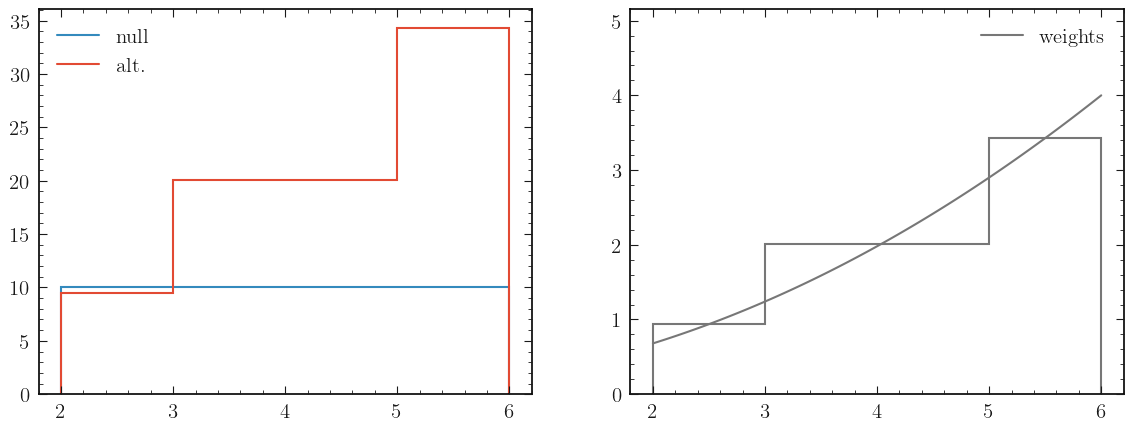

In [23]:
pars = [1., 1.1, 0.9]
plot.dists(cmod, pars, plot_weights=True)

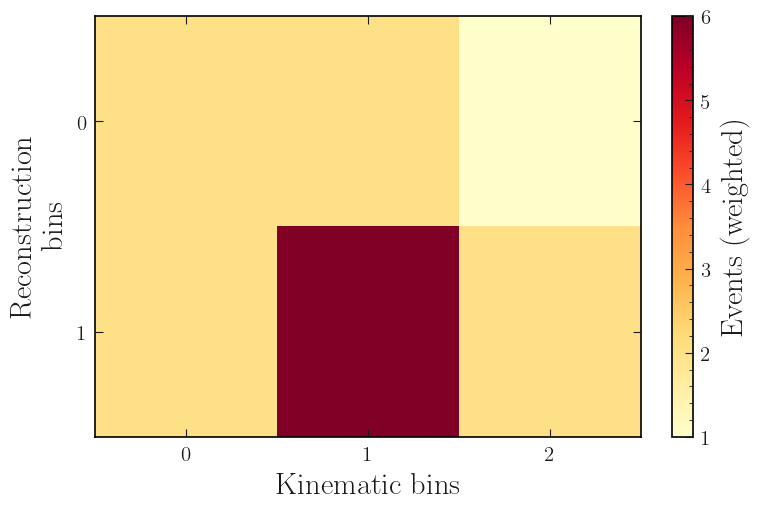

In [24]:
plot.map(cmod, cmap='YlOrRd', aspect='auto');

## Set up the model

In [25]:
spec = {
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "signal",
          "data": [5.0, 10.0],
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            }
          ]
        },
        {
          "name": "background",
          "data": [50.0, 60.0],
          "modifiers": [
            {
              "name": "uncorr_bkguncrt",
              "type": "shapesys",
              "data": [5.0, 12.0]
            }
          ]
        }
      ]
    }
  ]
}
model = pyhf.Model(spec)

custom_mod = {
                "name": "custom_modifier",
                "type": "custom",
                "data":
                    {
                        "expr": "custom_weight_fn",
                    }
              }

model = modifier.add_to_model(model, ['singlechannel'], ['signal'], cmod.expanded_pyhf, custom_mod)
model.spec

{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'signal',
     'data': [5.0, 10.0],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'custom_modifier',
       'type': 'custom',
       'data': {'expr': 'custom_weight_fn'}}]},
    {'name': 'background',
     'data': [50.0, 60.0],
     'modifiers': [{'name': 'uncorr_bkguncrt',
       'type': 'shapesys',
       'data': [5.0, 12.0]}]}]}]}

In [26]:
model.main_model.modifiers_appliers['custom'].param_viewer.allpar_viewer.names

('a', 'h_decorrelated[0]', 'h_decorrelated[1]', 'mu', 'uncorr_bkguncrt')

In [27]:
model.config.par_map

{'a': {'slice': slice(0, 1, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x149eeadd1660>},
 'h_decorrelated[0]': {'slice': slice(1, 2, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x149eeadd1600>},
 'h_decorrelated[1]': {'slice': slice(2, 3, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x149eeadd1630>},
 'mu': {'slice': slice(3, 4, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x149eeadd1690>},
 'uncorr_bkguncrt': {'slice': slice(4, 6, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_poisson at 0x149eeadd11b0>}}

In [28]:
cmod.corr_infos

{'h': {'mean': (1.0, 1.0),
  'uvec': array([[-0.54772256, -0.4472136 ],
         [-0.54772256,  0.4472136 ]])}}

## Generate some fake data

In [31]:
init = model.config.suggested_init()
init[0] = 5.

data = list(model.expected_actualdata(init)) + model.config.auxdata
data

[99.58333333333334, 170.66666666666666, 0.0, 0.0, 100.0, 25.0]

## Perform the fit

In [32]:
fixed = model.config.suggested_fixed()
# fixed[0] = True
fixed[1] = True
fixed[2] = True
fixed[3] = True

pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=True, strategy=1))
best_fit = pyhf.infer.mle.fit(data, model, fixed_params=fixed, return_uncertainties=True)

best_fit_dict = modifier.par_dict(model, best_fit)
# best_fit_dict = cmod.rotate_pars(best_fit_dict)
best_fit_dict

{'a': array([4.99836566, 0.65108537]),
 'h_decorrelated[0]': array([0., 0.]),
 'h_decorrelated[1]': array([0., 0.]),
 'mu': array([1., 0.]),
 'uncorr_bkguncrt': [[1.0001649714924825, 0.0931007011045834],
  [1.0006821768890635, 0.1839198295778896]]}

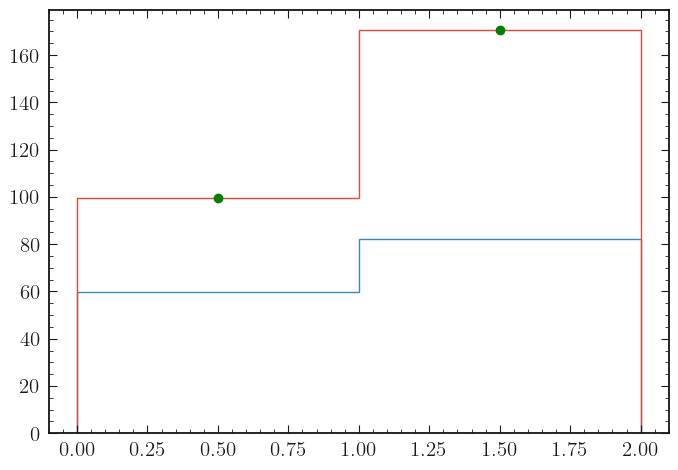

In [33]:
plt.stairs(model.expected_actualdata(model.config.suggested_init()))
plt.stairs(model.expected_actualdata(best_fit[:,0]))
# bin_cents = (binning[:-1] + binning[1:])/2
plt.plot([0.5, 1.5], data[:2], 'og')